### Using qq plot to test the assumption of normality
#### Up untill now we have been fitting a curve to the histogram of the log of the survey results.  After receiving the following feedback from Prof Davison at the EPFL stats dept we will look at this another way

> Better to use a normal QQ plot or normal probability plot (also called a rankit plot) to assess normality.  A histogram is a crude tool, especially in the tails.

#### Although we are not handling 'critical data' -- like drug efficiency, mortality rates or the returns on my IRA we (hammerdirt) take every opportunity to learn and apply feedback.  Besides this may make the model more precise in predictions about trash values in the future and/or changes year over year

#### Load the libraries needed:

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import re
import os
from scipy.stats import norm
import scipy.stats
import statsmodels.api as sm #<----- this is the library for doing the QQ plot
here = os.getcwd()
data = '/home/mw-shovel/web/notes/basel/data'
here

'/home/mw-shovel/web/notes/notes-hammerdirt.ch'

#### Get the data and any other 'objects' required

In [2]:
# in the note book we pickle everything for storage
# in the app we use json format, pickle is not secure for web apps (as far as I know)
slr = pd.read_pickle(data + '/combined.p')
mcb = pd.read_pickle(data + '/combined_mc.p')
mcb_slr = pd.read_pickle(data + '/mcb_slr.p')
g_all = pd.read_pickle(data + '/water_bodies_all.p')
g = pd.read_pickle(data + '/water_bodies.p')
codes = pd.read_pickle(data + '/codes.p')

In [3]:
mcb_slr.reset_index(inplace=True)

#### Run through the same checks and transformations as in the previous note book

In [4]:
# the records are stored as individual events per object type
# for example one record from the data base looks like this
mcb_slr.loc[1]

index                            1
code_id                        G27
date           2017-04-02 00:00:00
pcs_m                        0.429
length                          28
location_id     Aare_Bern_CaveltiN
quantity                        12
city                 Muri bei Bern
latitude                   46.9236
longitude                  7.47332
post                          3074
water                        river
pop                          13187
area                          7.63
pop_dens                   1728.31
day                              6
Name: 1, dtype: object

In [5]:
# need to combine records by date and location

dfA = mcb_slr.pivot_table('pcs_m', index=['date', 'day', 'water','city','location_id'], columns=['code_id'], fill_value=0)

In [6]:
# now all the records that have the same 'date', 'day', 'city' and 'location_id' are grouped together
# in other words all the results from one beach-litter inventory
dfA[:1]

,,,,code_id,G1,G10,G100,G101,G102,G11,G12,G124,G125,G126,...,G89,G9,G90,G91,G92,G93,G95,G96,G97,G99
date,day,water,city,location_id,,,,,,,,,,,,,,,,,,,,,
2015-11-23,0,lake,Montreux,Baye de Montreux - G,0.0,0.0,0.016393,0.0,0.0,0.016393,0.0,0.016393,0.0,0.016393,...,0.065574,0.0,0.0,0.0,0.0,0.0,0.147541,0.0,0.0,0.0


In [7]:
# add up all the columns (those with a 'G' label)
dfA['total'] = dfA[dfA.columns].sum(axis=1)

In [8]:
# get the first 10 records for Lac Leman
idx = pd.IndexSlice
dfA.loc[idx[:, :, :, :, g_all['Lac Léman']], 'total'][:10]
# this looks good

date        day  water  city      location_id         
2015-11-23  0    lake   Montreux  Baye de Montreux - G    5.721311
2015-11-24  1    lake   Montreux  Baye de Clarens         1.695652
2015-11-27  4    lake   Vevey     Veveyse                 4.075472
2015-12-01  1    lake   Vevey     Veveyse                 0.981132
2015-12-02  2    lake   Montreux  Baye de Clarens         0.681159
2015-12-04  4    lake   Montreux  Baye de Montreux - D    6.918033
                                  Baye de Montreux - G    8.377049
2015-12-07  0    lake   Vevey     Veveyse                 3.641509
2015-12-08  1    lake   Montreux  Baye de Clarens         3.391304
2015-12-10  3    lake   Montreux  Baye de Montreux - D    9.655738
Name: total, dtype: float64

In [9]:
dfA.reset_index(inplace=True)

#### Get down to just what is needed

In [10]:
# make a working copy
a = dfA.copy()
# grab only the columns we need to chart
a = a[['date','location_id','total']].copy()
# grab only the rows that are in the Group 'Lac Léman'
a = a.loc[a.location_id.isin(g_all['Lac Léman'])].copy()
# just to make sure its all good:
a[:5]
# its all good

code_id,date,location_id,total
0,2015-11-23,Baye de Montreux - G,5.721311
1,2015-11-24,Baye de Clarens,1.695652
2,2015-11-27,Veveyse,4.075472
3,2015-12-01,Veveyse,0.981132
4,2015-12-02,Baye de Clarens,0.681159


### The assumption is that a log transform makes the litter survey data "normal".
#### This is a common transformation, we have covered this alot in past and wont go into the details here
#### Just take a look at the two histograms:

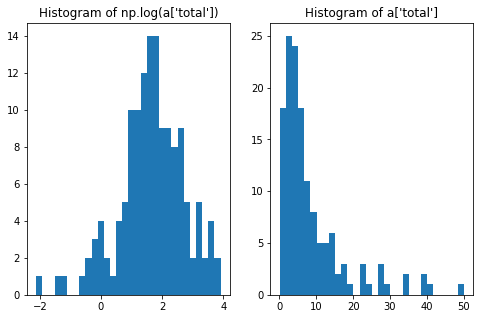

In [11]:
# first thing is to get the log of the total column
# put that in a seperate column
a['log'] = np.log(a['total'])
n_bins = 30

fig, axs = plt.subplots(1, 2, figsize=(8,5))
axs[0].hist(a['log'], bins=n_bins)
axs[1].hist(a['total'], bins=n_bins)
axs[0].set_title("Histogram of np.log(a['total'])")
axs[1].set_title("Histogram of a['total']")
plt.show()

#### Prof Davison is right (of course), the tails of both histograms are 'extended', the log is slightly skewed left and the 'total' is definiteley skewed right.

1. I don't think this means our assumption is wrong
2. Remember this is trash on the ground we are talking about here
3. We knew the histogram was skewed right thats why we take the log

#### Take a look at the distribution and see how 'tails' play out

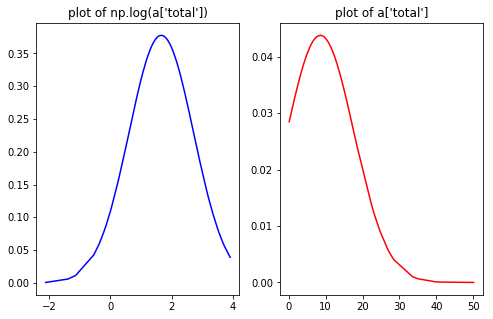

In [12]:
loc_log = np.mean(a['log'])
scale_log = np.std(a['log'])
loc = np.mean(a['total'])
scale = np.std(a['total'])

x_log = a['log'].sort_values()
y_log =  norm.pdf(x_log, loc_log, scale_log)
x_total= a['total'].sort_values()
y_total= norm.pdf(x_total, loc, scale)

fig, axs = plt.subplots(1, 2, figsize=(8,5))
axs[1].plot(x_total, y_total, color='r', label='plot_total')
axs[0].plot(x_log, y_log, color='b', label='plot log')
axs[0].set_title("plot of np.log(a['total'])")
axs[1].set_title("plot of a['total']")
plt.show()


### There it is even more obvious the log of the values has the extended tail to the left, and the 'totals' pushes to the right, this is more for me than for you, it helps if I can see what is going on.
#### So now its time to look at this with a QQ plot

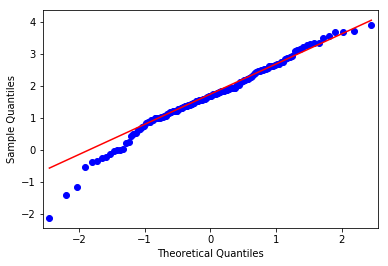

In [13]:
fig = sm.qqplot(x_log, scipy.stats.norm, loc=loc_log, scale=scale_log, line='q')
plt.show()

#### Indeed the data is not normal, but it is not bad either. What would happen if the the extreme records are excluded ?

1. Exclude all values less than -1
2. np.exp(-1) = 0.3678 or 37pcs of trash per 100/m of shoreline 
3. That is an acceptable value and the model can be modified where x >/= 0.3678 pcs/m
4. So 1 piece of trash every two or three meters (that can be any object)

In [14]:
x_22 = x_log[x_log > -1]
min(x_22)

-0.5447271754416719

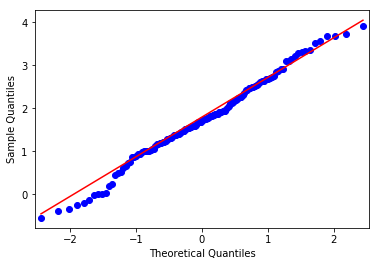

In [15]:
x_22_loc = np.mean(x_22)
x_22_scale = np.std(x_22)
fig = sm.qqplot(x_22, scipy.stats.norm, loc=x_22_loc, scale=x_22_scale, line='q')
plt.show()

#### Suppose the top and bottom 5% are extreme values and do not relfect the reality on the ground

1. This makes sense here (a few extreme values on the max side, and a few on the min side)
2. Cut the dist off from the bottom 5% and top 5%
3. This cuts out quite a few records(14) most of them from one location
4. The records that have extreme values can be set asisde and see if they have common cahracteristics

In [16]:
num_res = len(x_log)
low_end = np.percentile(x_log, 5)
top_end = np.percentile(x_log, 95)
x_log_2 = x_log[(x_log > low_end) & (x_log < top_end)]
x_log2_loc = np.mean(x_log_2)
x_log2_scale = np.std(x_log_2)

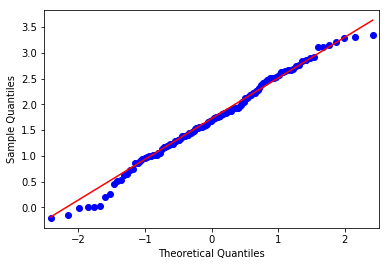

In [17]:
fig = sm.qqplot(x_log_2, scipy.stats.norm, loc=x_log2_loc, scale=x_log2_scale, line='q')
plt.show()

### So that is what it looks for the two year data on Lac Léman, apply the same principles to the larger data set that combines the SLR and MCBP data.

#### n=1009

1. If Professor Davisons observations hold true then the effect should be the same
2. There may even be a larger effect because the surveys on rivers have a lower average

In [18]:
# get the data
b = dfA.copy()
b = dfA[['date','location_id','total']].copy()
b['log'] = np.log(dfA['total'])

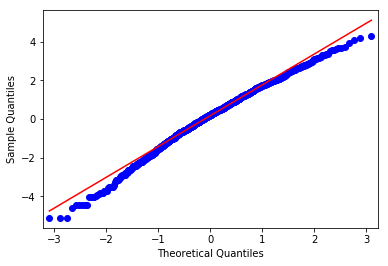

In [19]:
b_log_loc = np.mean(b['log'])
b_log_scale = np.std(b['log'])
fig = sm.qqplot(b['log'], scipy.stats.norm, loc=b_log_loc, scale=b_log_scale, line='q')
plt.show()

### Follow up questions:

1. How do these results change the year over year comparison? (I don't think they do, but we will ask someone)
2. Is there a better way to do this transform?

#### Remarks:

#### Thanks Prof Davison; this will go into the tool box for sure!
#### Unless there is some mathematical proof that these results are not comparable year over year because of extreme values then we will stick with the assumption that as the number of samples increases the distribution of np.log(results) of beach litter surveys can be approximated by a normal distribution with mu* and sigma*----

#### Things to do: Find the proof that this is not the correct course of action!